<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/Mask_R_CNN_Sample_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git
%cd Mask_RCNN
!pip install -r requirements.txt
%run -i setup.py install
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!git clone https://github.com/waleedka/coco.git
%cd coco/PythonAPI
%run -i setup.py build_ext --inplace
%run -i setup.py build_ext install
%cd /content/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
/content/Mask_RCNN


running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/parallel_model.py to p

zip_safe flag not set; analyzing archive contents...


creating 'dist/mask_rcnn-2.1-py3.6.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing mask_rcnn-2.1-py3.6.egg
Removing /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Copying mask_rcnn-2.1-py3.6.egg to /usr/local/lib/python3.6/dist-packages
mask-rcnn 2.1 is already the active version in easy-install.pth

Installed /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Processing dependencies for mask-rcnn==2.1
Finished processing dependencies for mask-rcnn==2.1
--2019-02-27 03:45:50--  https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github-production-release-asset-2e65be.s3.amazonaws.com/107595270/872d3234-d21f-11e7-9a51-7b4bc8075835?X-Amz-Algorithm

zip_safe flag not set; analyzing archive contents...
pycocotools.__pycache__._mask.cpython-36: module references __file__


creating 'dist/pycocotools-2.0-py3.6-linux-x86_64.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing pycocotools-2.0-py3.6-linux-x86_64.egg
removing '/usr/local/lib/python3.6/dist-packages/pycocotools-2.0-py3.6-linux-x86_64.egg' (and everything under it)
creating /usr/local/lib/python3.6/dist-packages/pycocotools-2.0-py3.6-linux-x86_64.egg
Extracting pycocotools-2.0-py3.6-linux-x86_64.egg to /usr/local/lib/python3.6/dist-packages
pycocotools 2.0 is already the active version in easy-install.pth

Installed /usr/local/lib/python3.6/dist-packages/pycocotools-2.0-py3.6-linux-x86_64.egg
Processing dependencies for pycocotools==2.0
Finished processing dependencies for pycocotools==2.0
/content/Mask_RCNN


https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
# sys.path.append(os.path.join(ROOT_DIR, "coco/PythonAPI"))  # To find local version
# import coco
from samples.coco import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [0]:
import google.colab
import keras

In [8]:
google.colab.drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from PIL import Image, ImageFilter, ImageDraw, ImageFont
import google.colab
import os

def show_results(results):
  # Visualize results
  r = results[0]
  print(r['rois'])
  print(r['class_ids'])
  print(r['scores'])

def resize(img,new_hight,rate=1):
  width,height = img.size
  rate =  new_hight / height
  new_width = width * rate 
  return img.resize((int(new_width),int(new_hight)),Image.LANCZOS)
  
def resize_to_target(img,new_size):
  short ,long = img.size
  if short < long:
    rate =  new_size / short
    new_height = long * rate 
    new_width = new_size
  else:
    rate =  new_size / long
    new_width = short * rate 
    new_height = new_size
  
  return img.resize((int(new_width),int(new_height)),Image.LANCZOS)

def get_center(img):
  return int(img.size[0] / 2)

def shift_to(img_center,target_position):
  gap = img_center - target_position
  shift = gap * -1
  print('shift',shift)
  return shift  

def get_object_center(rois,image):
  height = image.shape[0]
  width = image.shape[1]
  center = width / 2
#   print(width,height)
#   print('center',center)
  max_area = 0
  for i in range(len(rois)):
#     print(rois[i])
    start_height = rois[i][0] 
    start_width = rois[i][1] 
    end_height = rois[i][2] 
    end_width = rois[i][3] 
    
    height = end_height - start_height
    width = end_width - start_width
    
    area = height * width
#     print('area',area)
    if area < max_area:continue
    max_area = area
    center = start_width + width / 2
#     print('update center',center)
    
  return int(center)




In [0]:
def left_right_image(left_img_path,right_img_path,  canvas_size = 500):
  # load image
  iml = Image.open(left_img_path)
  imr = Image.open(right_img_path)
  
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # target position
  left_target = int(canvas_size / 4 * 1)
  right_target = int(canvas_size / 4 * 3)
  # resize image   
  iml2 = resize(iml,canvas_size)
  imr2 = resize(imr,canvas_size)
  # image to array
  left_image = keras.preprocessing.image.img_to_array(iml2)
  right_image = keras.preprocessing.image.img_to_array(imr2)
  # Run detection
  left_results = model.detect([left_image], verbose=1)
  right_results = model.detect([right_image], verbose=1)
  # get object centor
  iml2_center = get_object_center(left_results[0]['rois'],left_image)
  imr2_center = get_object_center(right_results[0]['rois'],right_image)
#   print('left_img_object_centor',iml2_center)
#   print('right_img_object_centor',imr2_center)

  # make mask
  mask_width = canvas_size / 2
  mask1 = Image.new("L",iml2.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((iml2_center - mask_width / 2, 0, canvas_size, canvas_size), fill=255)
  mask2 = Image.new("L",imr2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((imr2_center - mask_width / 2 ,0, imr2_center+ mask_width / 2, canvas_size), fill=255)

  # composite image 
  bg.paste(iml2,(shift_to(iml2_center,left_target),0),mask1)
  bg.paste(imr2,(shift_to(imr2_center,right_target),0),mask2)
  return bg

left_img_path /content/gdrive/My Drive/data/fashon_item_images/a04 3.jpg
right_img_path /content/gdrive/My Drive/data/fashon_item_images/a01 3.jpg
Processing 1 images
image                    shape: (500, 374, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (500, 374, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
shift -61
shift 261
left_img_path /content/gd

KeyboardInterrupt: ignored

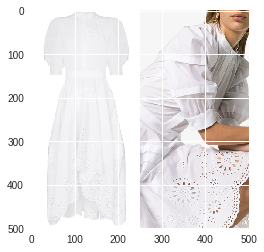

In [159]:
IMG_ROOT = ('/content/gdrive/My Drive/data/fashon_item_images')
EDITED_IMG_ROOT = ('/content/gdrive/My Drive/data/edited_images')

images = os.listdir(IMG_ROOT)
for i in range(len(images)-1):
  left_img_path = os.path.join(IMG_ROOT, images[i])
  right_img_path = os.path.join(IMG_ROOT, images[i+1])

  print('left_img_path',left_img_path)
  print('right_img_path',right_img_path)

  bg = left_right_image(left_img_path,right_img_path,500)
  plt.imshow(bg)
  file_name = f'sample{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  saved_image.show()

# PNG変換

In [0]:
def png_to_jpg(array_image):
  if len(array_image.shape) == 3:return array_image
  png_p = array_image.convert('P')
  rgb_im = png_p.convert('RGB')
  return np.array(rgb_im)

In [0]:
def left_right_up_down_image(left_img_path,right_up_img_path,right_down_img_path,  canvas_size = 500):
 
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # target position
  left_target = int(canvas_size / 4 * 1)
  right_target = int(canvas_size / 4 * 3)
  
  # load image
  im1 = Image.open(left_img_path)
  im2 = Image.open(right_up_img_path)
  im3 = Image.open(right_down_img_path)
  
  # resize image   
  im1 = resize(im1,canvas_size)
  im2 = resize_to_target(im2,canvas_size/2)
  im3 = resize_to_target(im3,canvas_size/2)
  # image to array
  r_im1 = keras.preprocessing.image.img_to_array(im1)
  r_im2 = keras.preprocessing.image.img_to_array(im2)
  r_im3 = keras.preprocessing.image.img_to_array(im3)
  # Run detection
  results1 = model.detect([r_im1], verbose=1)
  results2 = model.detect([r_im2], verbose=1)
  results3 = model.detect([r_im3], verbose=1)
  
  # get object centor
  im1_center = get_object_center(results1[0]['rois'],r_im1)
  im2_center = get_object_center(results2[0]['rois'],r_im2)
  im3_center = get_object_center(results3[0]['rois'],r_im3)
#   print('left_img_object_centor',iml2_center)
#   print('right_img_object_centor',imr2_center)

  # make mask
  mask_width = canvas_size / 2
  mask1 = Image.new("L",im1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((im1_center - mask_width / 2, 0, canvas_size, canvas_size), fill=255)
  mask2 = Image.new("L",im2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((im2_center - mask_width / 2 ,0, canvas_size, canvas_size/2), fill=255)
  mask3 = Image.new("L",im3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((im3_center - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)
  
  # composite image 
  bg.paste(im1,(shift_to(im1_center,left_target),0),mask1)
  bg.paste(im2,(shift_to(im2_center,right_target),0),mask2)
  bg.paste(im3,(shift_to(im3_center,right_target),int(canvas_size/2)),mask3)
  return bg



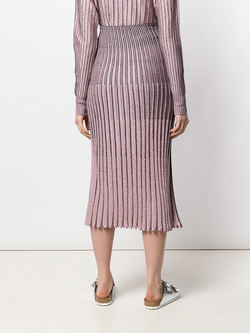

In [155]:

im1 = Image.open(left_img_path)
resize_img_to_target(im1,canvas_size/2)

left_img_path /content/gdrive/My Drive/data/fashon_item_images/a04 3.jpg
right_up_img_path /content/gdrive/My Drive/data/fashon_item_images/a01 3.jpg
right_down_img_path /content/gdrive/My Drive/data/fashon_item_images/a03 3.jpg
Processing 1 images
image                    shape: (500, 374, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (333, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min: 

ValueError: ignored

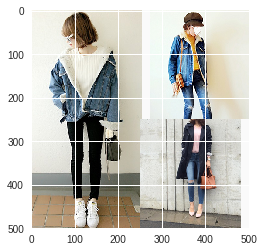

In [181]:
images = os.listdir(IMG_ROOT)
for i in range(len(images)-2):
  left_img_path = os.path.join(IMG_ROOT, images[i])
  right_up_img_path = os.path.join(IMG_ROOT, images[i+1])
  right_down_img_path = os.path.join(IMG_ROOT, images[i+2])
  
  print('left_img_path',left_img_path)
  print('right_up_img_path',right_up_img_path)
  print('right_down_img_path',right_down_img_path)

  bg = left_right_up_down_image(left_img_path,right_up_img_path,right_down_img_path,  canvas_size = 500)
  plt.imshow(bg)
  file_name = f'sample{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  saved_image.show()